In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import utils
import yieldcurve as yc

In [2]:
portfolio, market = utils.load_data()
NOW = utils.set_now()

In [3]:
def cashflow(rate=0, maturity=1, volume=1, payment_type='BULLET'):
    if payment_type == 'BULLET':
        interest = np.full(maturity, rate) * volume
        capital = np.zeros(maturity)
        capital[-1] = volume
        remaining = np.full(maturity, volume)-capital
        cashflow = capital + interest
    elif payment_type == 'LINEAR':
        # Calculate capital
        capital = np.repeat(1/maturity, maturity) * volume
        # Calculate remaining balance after each capital payment
        remaining = np.hstack([volume, volume - np.cumsum(capital)])
        # Calculate interest payment for each period
        interest = remaining[:maturity] * rate
        # Calculate total cash flow for each period
        cashflow = capital + interest
#     elif payment_type == 'ANNUITY':
#         interest = np.zeros(maturity)
#         capital = np.zeros(maturity)
#         cashflow = np.zeros(maturity)
#         remaining = volume
#         if isinstance(rate, (int, float)):
#             rate = np.full(maturity, rate)
#         for i in range(maturity):
#             discount_factor = 1 - (1 + rate[i]) ** -(maturity - i + 1)
#             cashflow[i] = (rate[i] / discount_factor) * remaining if rate[i] != 0 else remaining / (maturity - i + 1)
#             interest[i] = remaining * rate[i]
#             capital[i] = cashflow[i] - interest[i]
#             remaining -= capital[i]

    cf_df = pd.DataFrame({'cashflow': cashflow, 'interest': interest, 'capital': capital, 'remaining': remaining})
    return cf_df

In [4]:
volume = 75000
maturity = 36
rate = 0.01
bull = cashflow(rate,maturity,volume,payment_type="BULLET")

In [5]:
import datetime
import utils
from nelson_siegel_svensson.calibrate import calibrate_nss_ols


class YieldCurve:
    
    
    def __init__(self, curve_type):
        """ Initialize parameters """
        self.curve_type = curve_type
        self._data = None
        self._curve = None
        self._status = None
        self._now = utils.set_now()
        
        
    def fit(self, market_data, plot=False):
        """ 
        Fit Nelson-Siegel-Svensson model to the observed yields
        :param market_data:
        :param plot:
        """
        self._data = market_data[market_data['type'] == self.curve_type].copy()
        # Calculate time difference in years between now and expiry
        self._data['maturity'] = self._data['date'].apply(lambda date: utils.time_difference_years(date, self._now))
        # Fit the Nelson-Siegel-Svensson model to our yield data
        self._curve, self._status = calibrate_nss_ols(np.ravel(self._data['maturity']), np.ravel(self._data['rate']))

        if plot:
            self._plot_spot_yields(self._data['maturity'], self._data['rate'])
        
        
    def get_spot_yields(self, dates, plot=False):
        """ Gets the spot yield for dates based on Nelson-Siegel-Svensson model """
        maturities = utils.time_difference_years_from_list(dates, self._now)
        yields = self._curve(maturities)
        if plot:
            self._plot_spot_yields(dates, yields)
        return pd.DataFrame({"date": dates, "rate": yields})
         
        
    def _plot_spot_yields(self, times, rates):
        """ Plots the yields and the Nelson-Siegel-Svensson model vs dates of maturity """ 
        if isinstance(times[0], datetime.datetime):
            times_type = 'dates'
            times_scale = ''
            continuous_dates = utils.datetime_range(np.min(times), np.max(times), 100)
            continuous_maturities = utils.time_difference_years_from_list(continuous_dates, self._now)
            continuous_times = continuous_dates
        elif isinstance(times[0], float):
            times_type = 'times'
            times_scale = ' in years'
            continuous_maturities = np.linspace(np.min(times), np.max(times), 100)
            continuous_times = continuous_maturities
        else:
            raise TypeError('times can be either iterables of datetime.datetime or float numbers')
        
        plt.scatter(times, rates,
                    label='Spot Yields', marker='o', color='black', s=10)
        plt.plot(continuous_times, self._curve(continuous_maturities),
                 label='Nelson-Siegel-Svensson', color='gray', linestyle='-')
        
        plt.title(f'Yield Curve vs Maturity {times_type.capitalize()}')
        plt.xlabel(f'Maturity {times_type}' + times_scale)
        plt.ylabel('Yield in basis points')
        plt.legend()
        plt.show()
        
        
    def get_forward_yields(self, dates, plot=False):
        """ Gets forward yields """
        maturities = utils.time_difference_years_from_list(dates, self._now)
        rates = self._curve(maturities)
        rates = np.divide(rates, 10000)
        interests = np.power(np.add(1, rates), maturities)
        interests_shifted = np.concatenate(([1], np.roll(interests, shift=1)[1:]))
        forwards = np.multiply(np.add(np.divide(interests, interests_shifted), -1), 10000)
        
        if plot:
            self._plot_forward_yields(dates, forwards)
            
        return forwards
    
    
    def _plot_forward_yields(self, dates, rates):
        """ Plots forward yields """
        plt.scatter(dates, rates, label='Forward Yields',
                    marker='o', color='black', s=10)
        plt.plot(dates, rates, color='gray', linestyle='-')
        plt.title('Forward Yields vs Maturity Dates')
        plt.xlabel('Marurity date')
        plt.ylabel('Yield in basis points')
        plt.legend()
        plt.show()
        


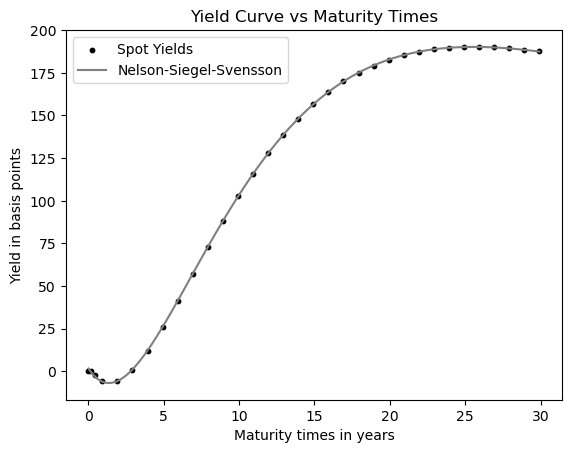

In [6]:
EUR01 = YieldCurve(curve_type='EUR01')
EUR01.fit(market, plot=True)

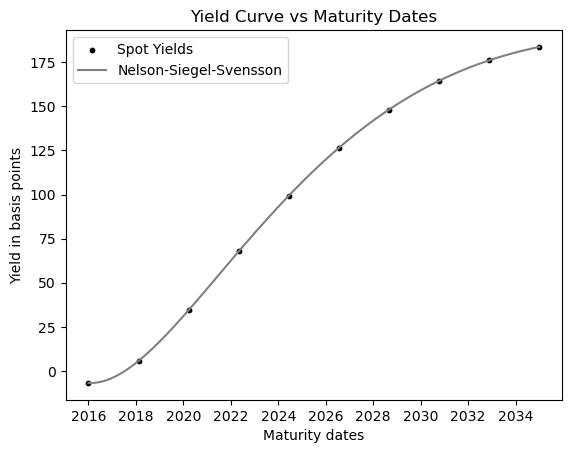

In [7]:
date_list = utils.datetime_range('2016-01-01', '2035-01-01', 10)
spot_yields = EUR01.get_spot_yields(date_list, plot=True)

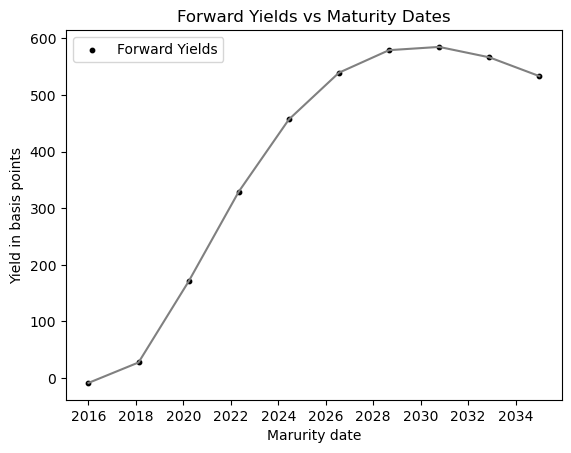

In [8]:
forward_yields = EUR01.get_forward_yields(date_list, plot=True)

In [9]:
from dateutil.relativedelta import relativedelta
new_date = start_date + relativedelta(years=loan_length)

NameError: name 'start_date' is not defined

In [ ]:
portfolio

In [ ]:
from datetime import datetime

def datetime_range(length, start_date, end_date= ''):
    """ Returns a range of #length datetimes starting from start_date and ending at end_date """
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    time_difference = end_date - start_date
    interval = time_difference / (length - 1)
    date_range = [start_date + i * interval for i in range(length)]
    return date_range
    

In [ ]:
datetime_range(10, start_date = '2010-09-09')

In [ ]:
type(date_list[0])